In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [3]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [4]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


In [5]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()

In [6]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size
    
    accuracy = 100*correct
    return accuracy, loss

In [7]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])
    
    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

In [8]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

    # reset weights
    def reset_parameters(self):
        for layer in self.layers_stack:
             if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)  # Xavier/Glorot initialization
                nn.init.constant_(layer.bias, 0)       # Initialize bias to 0

        

In [9]:
nonlinear_model_ReLU = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model_ReLU.parameters(), lr=0.05)

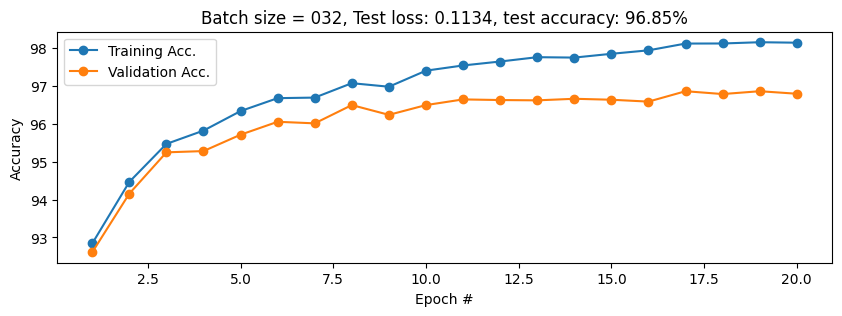

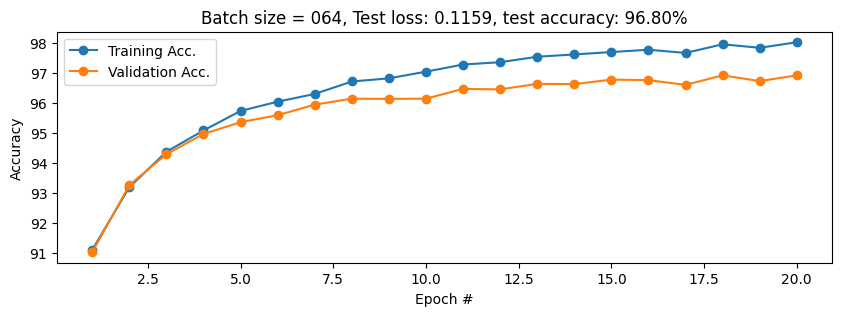

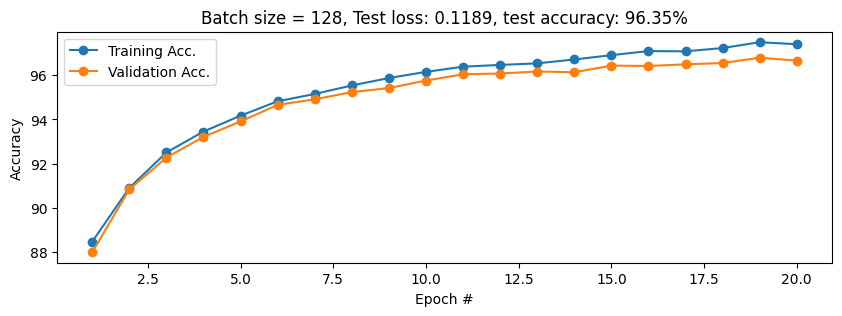

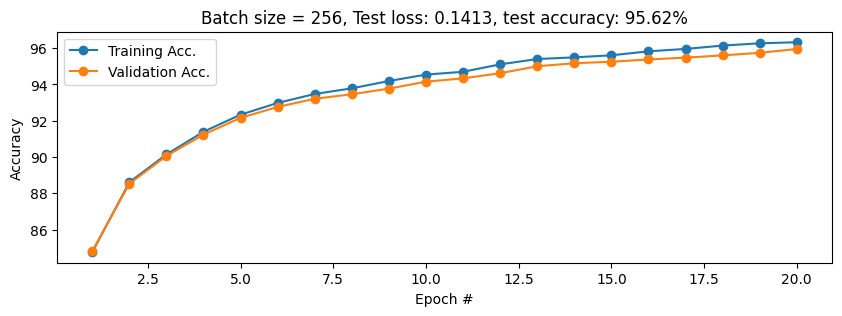

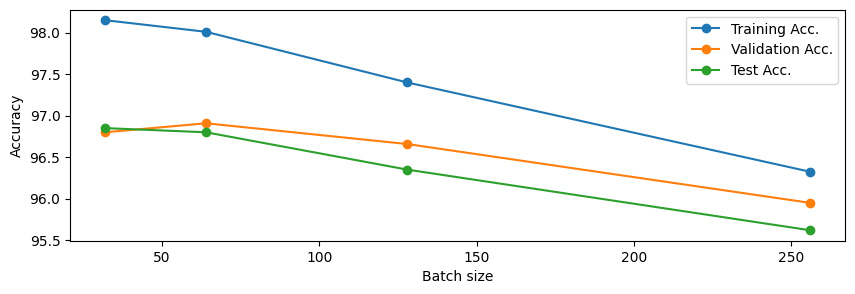

In [10]:
# Effects of Batch sizes 

epochs = 20
batch_size_list = [32, 64, 128, 256]
train_acc_list = []
val_acc_list = []
test_acc_list = []

for i in range(len(batch_size_list)):

    # Initialize model, train and validation arrays
    nonlinear_model_ReLU.reset_parameters()
    train_acc_all = []
    val_acc_all = []
    
    batch_size = batch_size_list[i]
    # The dataloader makes our dataset iterable 
    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
    
    
    for j in range(epochs):
        train_one_epoch(train_dataloader, nonlinear_model_ReLU, loss_fn, optimizer)
        
        # checking on the training loss and accuracy once per epoch
        acc, loss = evaluate(train_dataloader, nonlinear_model_ReLU, loss_fn)
        train_acc_all.append(acc)
        #print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
        
        # checking on the validation loss and accuracy once per epoch
        val_acc, val_loss = evaluate(val_dataloader, nonlinear_model_ReLU, loss_fn)
        val_acc_all.append(val_acc)
        #print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

    # Plot training/validation accuraty
    pltsize=1
    epochs_range = list(range(1,len(train_acc_all)+1))
    
    plt.figure(figsize=(10*pltsize, 3 * pltsize))
    plt.plot(epochs_range, train_acc_all,label = 'Training Acc.' ,marker='o')
    plt.plot(epochs_range, val_acc_all, label = 'Validation Acc.',marker='o' )
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend()
    
    
    #create dataloader for test data
    # The dataloader makes our dataset iterable 
    batch_size_test = 256
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)
    
    acc_test, loss_test = evaluate(test_dataloader, nonlinear_model_ReLU, loss_fn)
    #print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))
    plt.title('Batch size = %03d, Test loss: %.4f, test accuracy: %.2f%%' % (batch_size_list[i],loss_test, acc_test))

    train_acc_list.append(train_acc_all[-1])
    val_acc_list.append(val_acc_all[-1])
    test_acc_list.append(acc_test)

plt.figure(figsize=(10*pltsize, 3 * pltsize))
plt.plot(batch_size_list, train_acc_list,label = 'Training Acc.' ,marker='o')
plt.plot(batch_size_list, val_acc_list, label = 'Validation Acc.' ,marker='o')
plt.plot(batch_size_list, test_acc_list, label = 'Test Acc.',marker='o')
plt.xlabel('Batch size')
plt.ylabel('Accuracy')
plt.legend()

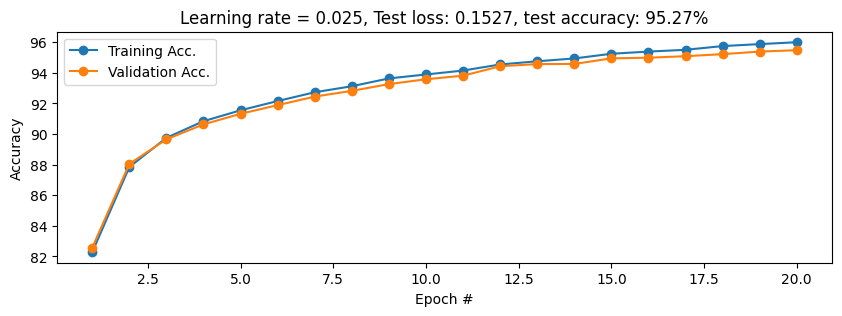

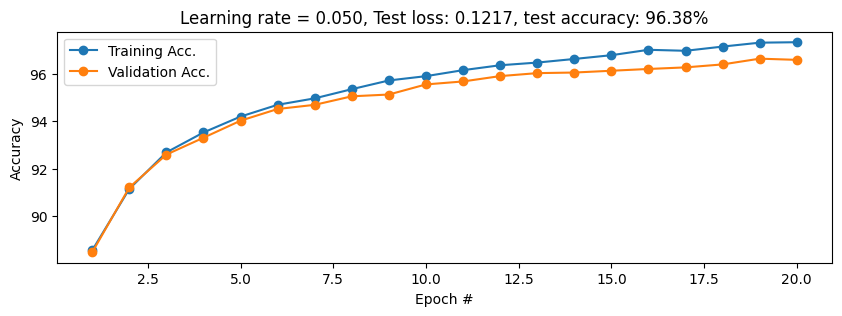

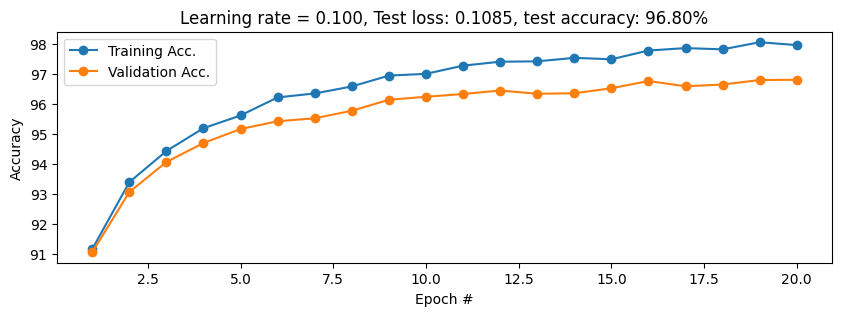

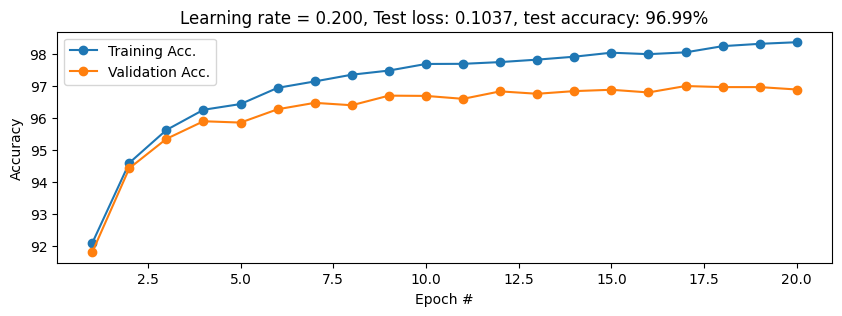

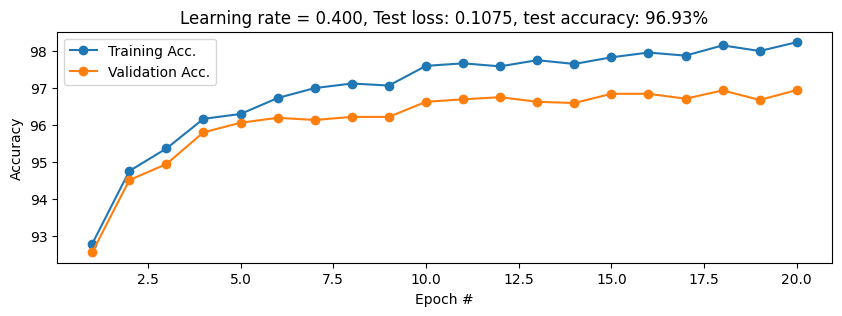

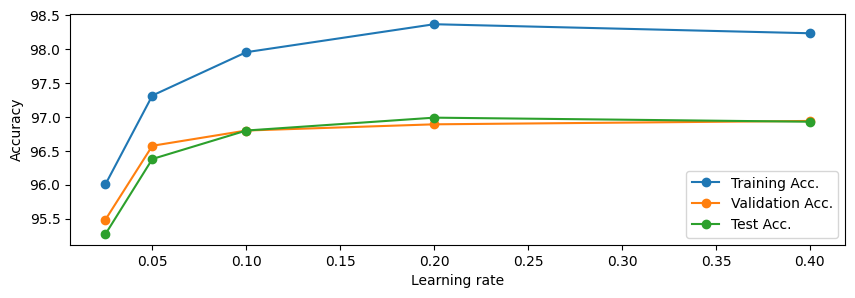

In [11]:
# Effects of Learning rates

epochs = 20
lr_list = [0.025, 0.05, 0.1, 0.2, 0.4]
train_acc_list = []
val_acc_list = []
test_acc_list = []

for i in range(len(lr_list)):

    # Initialize model, train and validation arrays
    nonlinear_model_ReLU.reset_parameters()
    train_acc_all = []
    val_acc_all = []
    
    batch_size = 128
    # The dataloader makes our dataset iterable 
    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
    
    
    for j in range(epochs):
        optimizer = torch.optim.SGD(nonlinear_model_ReLU.parameters(), lr=lr_list[i])
        train_one_epoch(train_dataloader, nonlinear_model_ReLU, loss_fn, optimizer)
        
        # checking on the training loss and accuracy once per epoch
        acc, loss = evaluate(train_dataloader, nonlinear_model_ReLU, loss_fn)
        train_acc_all.append(acc)
        #print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
        
        # checking on the validation loss and accuracy once per epoch
        val_acc, val_loss = evaluate(val_dataloader, nonlinear_model_ReLU, loss_fn)
        val_acc_all.append(val_acc)
        #print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

    # Plot training/validation accuraty
    pltsize=1
    epochs_range = list(range(1,len(train_acc_all)+1))
    
    plt.figure(figsize=(10*pltsize, 3 * pltsize))
    plt.plot(epochs_range, train_acc_all,label = 'Training Acc.' ,marker='o')
    plt.plot(epochs_range, val_acc_all, label = 'Validation Acc.',marker='o' )
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend()
    
    
    #create dataloader for test data
    # The dataloader makes our dataset iterable 
    batch_size_test = 256
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)
    
    acc_test, loss_test = evaluate(test_dataloader, nonlinear_model_ReLU, loss_fn)
    #print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))
    plt.title('Learning rate = %.3f, Test loss: %.4f, test accuracy: %.2f%%' % (lr_list[i],loss_test, acc_test))

    train_acc_list.append(train_acc_all[-1])
    val_acc_list.append(val_acc_all[-1])
    test_acc_list.append(acc_test)

plt.figure(figsize=(10*pltsize, 3 * pltsize))
plt.plot(lr_list, train_acc_list,label = 'Training Acc.' ,marker='o')
plt.plot(lr_list, val_acc_list, label = 'Validation Acc.' ,marker='o')
plt.plot(lr_list, test_acc_list, label = 'Test Acc.',marker='o')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.legend()

In [12]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Sigmoid(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Sigmoid(),
           nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Sigmoid(),
           nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

    # reset weights
    def reset_parameters(self):
        for layer in self.layers_stack:
             if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)  # Xavier/Glorot initialization
                nn.init.constant_(layer.bias, 0)       # Initialize bias to 0

In [13]:
nonlinear_model_Sigmoid = NonlinearClassifier()

In [14]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

     # reset weights
    def reset_parameters(self):
        for layer in self.layers_stack:
             if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)  # Xavier/Glorot initialization
                nn.init.constant_(layer.bias, 0)       # Initialize bias to 0


In [15]:
nonlinear_model_Tanh = NonlinearClassifier()

In [16]:
def initialize_model(status):
        match status:
            case 0:
                nonlinear_model_ReLU.reset_parameters()
            case 1:
                nonlinear_model_Sigmoid.reset_parameters()
            case 2:
                nonlinear_model_Tanh.reset_parameters()

In [17]:
def model_case(status):
    match status:
        case 0:
            optimizer = torch.optim.SGD(nonlinear_model_ReLU.parameters(), lr=0.05)
            train_one_epoch(train_dataloader, nonlinear_model_ReLU, loss_fn, optimizer)
            
            # checking on the training loss and accuracy once per epoch
            acc, loss = evaluate(train_dataloader, nonlinear_model_ReLU, loss_fn)
            train_acc_all.append(acc)
            #print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
            
            # checking on the validation loss and accuracy once per epoch
            val_acc, val_loss = evaluate(val_dataloader, nonlinear_model_ReLU, loss_fn)
            val_acc_all.append(val_acc)
        case 1:
            optimizer = torch.optim.SGD(nonlinear_model_Sigmoid.parameters(), lr=0.05)
            train_one_epoch(train_dataloader, nonlinear_model_Sigmoid, loss_fn, optimizer)
            
            # checking on the training loss and accuracy once per epoch
            acc, loss = evaluate(train_dataloader, nonlinear_model_Sigmoid, loss_fn)
            train_acc_all.append(acc)
            #print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
            
            # checking on the validation loss and accuracy once per epoch
            val_acc, val_loss = evaluate(val_dataloader, nonlinear_model_Sigmoid, loss_fn)
            val_acc_all.append(val_acc)
        case 2:
            optimizer = torch.optim.SGD(nonlinear_model_Tanh.parameters(), lr=0.05)
            train_one_epoch(train_dataloader, nonlinear_model_Tanh, loss_fn, optimizer)
            
            # checking on the training loss and accuracy once per epoch
            acc, loss = evaluate(train_dataloader, nonlinear_model_Tanh, loss_fn)
            train_acc_all.append(acc)
            #print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
            
            # checking on the validation loss and accuracy once per epoch
            val_acc, val_loss = evaluate(val_dataloader, nonlinear_model_Tanh, loss_fn)
            val_acc_all.append(val_acc)
            
    return train_acc_all, val_acc_all

In [18]:
def test_model_case(status):
    match status:
        case 0:
            acc_test, loss_test = evaluate(test_dataloader, nonlinear_model_ReLU, loss_fn)
            act_fun = 'ReLU'
        case 1:
            acc_test, loss_test = evaluate(test_dataloader, nonlinear_model_Sigmoid, loss_fn)
            act_fun = 'Sigmoid'
        case 2:
            acc_test, loss_test = evaluate(test_dataloader, nonlinear_model_Tanh, loss_fn)
            act_fun = 'Tanh'
            
    return acc_test, loss_test, act_fun

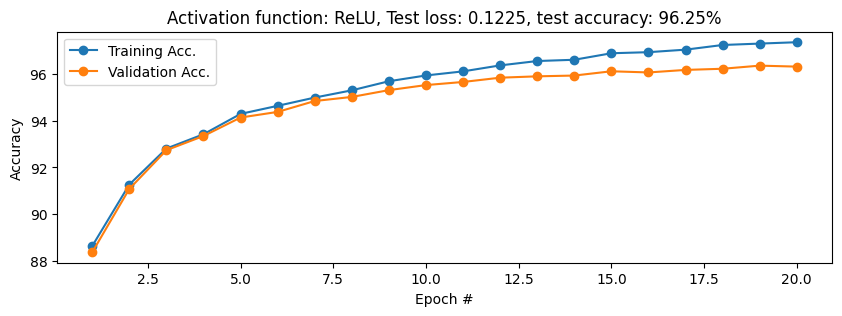

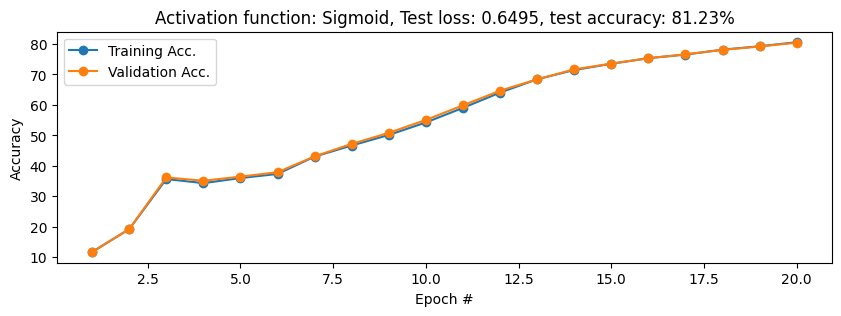

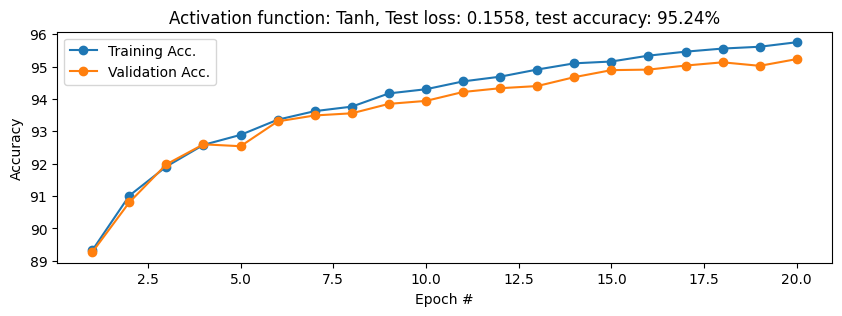

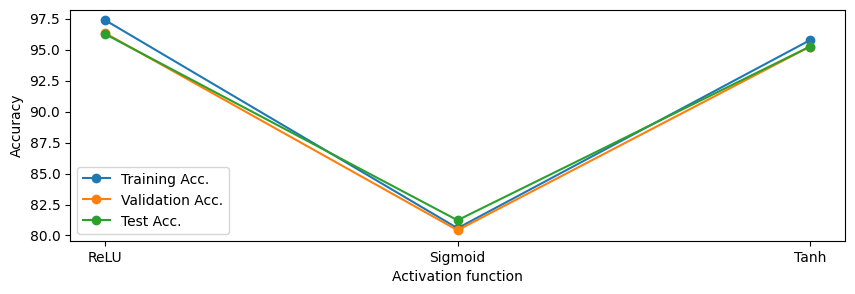

In [19]:
# Effects of Activation Function

epochs = 20
train_acc_list = []
val_acc_list = []
test_acc_list = []

for i in range(3):

    # Select nonlinear model
    nonlinear_model, act_fun = model_case(i)
    
    # Initialize model, train and validation arrays
    initialize_model(i)
    train_acc_all = []
    val_acc_all = []
    
    batch_size = 128
    # The dataloader makes our dataset iterable 
    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
    
    
    for j in range(epochs):
        train_acc_all, val_acc_all = model_case(i)

    # Plot training/validation accuraty
    pltsize=1
    epochs_range = list(range(1,len(train_acc_all)+1))
    
    plt.figure(figsize=(10*pltsize, 3 * pltsize))
    plt.plot(epochs_range, train_acc_all,label = 'Training Acc.' ,marker='o')
    plt.plot(epochs_range, val_acc_all, label = 'Validation Acc.',marker='o' )
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend()
    
    
    #create dataloader for test data
    # The dataloader makes our dataset iterable 
    batch_size_test = 256
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)
    acc_test, loss_test, act_fun = test_model_case(i)
    
    #print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))
    plt.title('Activation function: %s, Test loss: %.4f, test accuracy: %.2f%%' % (act_fun,loss_test, acc_test))

    train_acc_list.append(train_acc_all[-1])
    val_acc_list.append(val_acc_all[-1])
    test_acc_list.append(acc_test)

plt.figure(figsize=(10*pltsize, 3 * pltsize))
plt.plot([1,2,3], train_acc_list,label = 'Training Acc.' ,marker='o')
plt.plot([1,2,3], val_acc_list, label = 'Validation Acc.' ,marker='o')
plt.plot([1,2,3], test_acc_list, label = 'Test Acc.',marker='o')
plt.xlabel('Activation function')
plt.ylabel('Accuracy')
plt.xticks([1, 2, 3], ['ReLU', 'Sigmoid', 'Tanh'])
plt.legend()